<h2> 1. Classification using Random Forest </h2>

In [1]:
#import libraries
import yfinance as yf
import pandas as pd
import talib # pip install TA_Lib-0.4.24-cp38-cp38-win_amd64
from talib import abstract #conda install -c conda-forge ta-lib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import joblib

pd.set_option('display.max_rows', 600)

In [2]:
#import yahoo stock data
data = yf.Ticker('SPY').history(start='1990-01-29') #get the yahoo stock data start from the beginning
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
1993-01-29 00:00:00-05:00,25.140217,25.140217,25.015141,25.122349,1003200,0.0,0.0,0.0
1993-02-01 00:00:00-05:00,25.140233,25.301044,25.140233,25.301044,480500,0.0,0.0,0.0
1993-02-02 00:00:00-05:00,25.283146,25.372486,25.229542,25.354618,201300,0.0,0.0,0.0
1993-02-03 00:00:00-05:00,25.390369,25.640520,25.372501,25.622652,529400,0.0,0.0,0.0
1993-02-04 00:00:00-05:00,25.711983,25.783455,25.426096,25.729851,531500,0.0,0.0,0.0


In [3]:
data.columns = ['open','high','low','close','volume','dividends','split', 'capital'] #renamce columns
data.index = pd.to_datetime(data.index.date)
data.head()

,open,high,low,close,volume,dividends,split,capital
1993-01-29,25.140217,25.140217,25.015141,25.122349,1003200,0.0,0.0,0.0
1993-02-01,25.140233,25.301044,25.140233,25.301044,480500,0.0,0.0,0.0
1993-02-02,25.283146,25.372486,25.229542,25.354618,201300,0.0,0.0,0.0
1993-02-03,25.390369,25.640520,25.372501,25.622652,529400,0.0,0.0,0.0
1993-02-04,25.711983,25.783455,25.426096,25.729851,531500,0.0,0.0,0.0


In [4]:
#data pre-processing of cyclical features
#this step helps classification on time-series data
#source: http://blog.davidkaleko.com/feature-engineering-cyclical-features.html
#note year is not cyclical features
data['year'] = data.index.to_series().dt.year.to_list()
data['month'] = data.index.to_series().dt.month.to_list()
data['day'] = data.index.to_series().dt.day.to_list()
data['weekday'] = data.index.to_series().dt.dayofweek.to_list()

data['month_sin'] = np.sin(data.month*(2.*np.pi/12))
data['month_cos'] = np.cos(data.month*(2.*np.pi/12))

data['day_sin'] = np.sin(data.day*(2.*np.pi/30))
data['day_cos'] = np.cos(data.day*(2.*np.pi/30))

data['weekday_sin'] = np.sin(data.weekday*(2.*np.pi/7))
data['weekday_cos'] = np.cos(data.weekday*(2.*np.pi/7))

data.head()

,open,high,low,close,volume,dividends,split,capital,year,month,day,weekday,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos
1993-01-29,25.140217,25.140217,25.015141,25.122349,1003200,0.0,0.0,0.0,1993,1,29,4,0.500000,0.866025,-0.207912,0.978148,-0.433884,-0.900969
1993-02-01,25.140233,25.301044,25.140233,25.301044,480500,0.0,0.0,0.0,1993,2,1,0,0.866025,0.500000,0.207912,0.978148,0.000000,1.000000
1993-02-02,25.283146,25.372486,25.229542,25.354618,201300,0.0,0.0,0.0,1993,2,2,1,0.866025,0.500000,0.406737,0.913545,0.781831,0.623490
1993-02-03,25.390369,25.640520,25.372501,25.622652,529400,0.0,0.0,0.0,1993,2,3,2,0.866025,0.500000,0.587785,0.809017,0.974928,-0.222521
1993-02-04,25.711983,25.783455,25.426096,25.729851,531500,0.0,0.0,0.0,1993,2,4,3,0.866025,0.500000,0.743145,0.669131,0.433884,-0.900969


##### The date information is extracted from the index column and its relative trigonometry functions are also computed for time-series classification.

In [5]:
#compute indicators for the dataset
ind_list = talib.get_functions() #get all indicators for financial analysis

temp = data
#compute each indicator for the dataset
#source: 
for ind in ind_list:
    if ind != 'MAVP': #MAVP needs periods
        output = eval('abstract.' + ind + '(data)')
    else:
        output = eval('talib.MAVP(data.close, periods=data.index.to_series(), minperiod=2, maxperiod=30, matype=0)')
    output.name = ind.lower() if type(output) == pd.core.series.Series else None #rename for 1D output
    temp = pd.merge(temp, pd.DataFrame(output), 
                    left_on = temp.index, 
                    right_on = output.index).set_index('key_0') #merge output with original data
ind_data = temp
ind_data.head()

,open,high,low,close,volume,dividends,split,capital,year,month,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
key_0,,,,,,,,,,,,,,,,,,,,,
1993-01-29,25.140217,25.140217,25.015141,25.122349,1003200,0.0,0.0,0.0,1993,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.165714e+05,NaN,1003200.0
1993-02-01,25.140233,25.301044,25.140233,25.301044,480500,0.0,0.0,0.0,1993,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0.178696,1.197071e+06,NaN,1483700.0
1993-02-02,25.283146,25.372486,25.229542,25.354618,201300,0.0,0.0,0.0,1993,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0.142944,1.348046e+06,NaN,1685000.0
1993-02-03,25.390369,25.640520,25.372501,25.622652,529400,0.0,0.0,0.0,1993,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0.285902,1.806860e+06,NaN,2214400.0
1993-02-04,25.711983,25.783455,25.426096,25.729851,531500,0.0,0.0,0.0,1993,2,...,NaN,0.220867,NaN,0.048782,NaN,NaN,0.357359,2.178910e+06,NaN,2745900.0


##### All the indices from talib are computed. This increases the degree of freedom when performing feature selection as more combinations of features are provided. However, more or less features does not necessarily mean better or worse prediction.

In [6]:
#check null
ind_data.isnull().sum().describe()

count     193.000000
mean       88.813472
std       770.784088
min         0.000000
25%         0.000000
50%         0.000000
75%        14.000000
max      7600.000000
dtype: float64

##### The statistics tells that may indices contains null/na/nan values

In [7]:
#remove column that has a lot of null (3% of the sample number)
#otherwise replace null by mean
clean_data = ind_data
for col in clean_data.columns:
    if clean_data[col].isnull().sum() > 0.03*len(clean_data):
        clean_data.drop(col, axis=1, inplace=True)
clean_data = clean_data.fillna(clean_data.mean())
clean_data.head()

,open,high,low,close,volume,dividends,split,capital,year,month,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
key_0,,,,,,,,,,,,,,,,,,,,,
1993-01-29,25.140217,25.140217,25.015141,25.122349,1003200,0.0,0.0,0.0,1993,1,...,0.049175,1.094063,136.680431,3.014749,1.891226,1.416728,1.897901,7.165714e+05,1.859863e+07,1003200.0
1993-02-01,25.140233,25.301044,25.140233,25.301044,480500,0.0,0.0,0.0,1993,2,...,0.049175,1.094063,136.680431,3.014749,1.891226,1.416728,0.178696,1.197071e+06,1.859863e+07,1483700.0
1993-02-02,25.283146,25.372486,25.229542,25.354618,201300,0.0,0.0,0.0,1993,2,...,0.049175,1.094063,136.680431,3.014749,1.891226,1.416728,0.142944,1.348046e+06,1.859863e+07,1685000.0
1993-02-03,25.390369,25.640520,25.372501,25.622652,529400,0.0,0.0,0.0,1993,2,...,0.049175,1.094063,136.680431,3.014749,1.891226,1.416728,0.285902,1.806860e+06,1.859863e+07,2214400.0
1993-02-04,25.711983,25.783455,25.426096,25.729851,531500,0.0,0.0,0.0,1993,2,...,0.049175,0.220867,136.680431,0.048782,1.891226,1.416728,0.357359,2.178910e+06,1.859863e+07,2745900.0


##### As the nulls occurs within the indices not the original data, replacing some of them rather than removing all of them maintains the variability of the dataset. Other than mean, median or mod can also be used to replace the null.

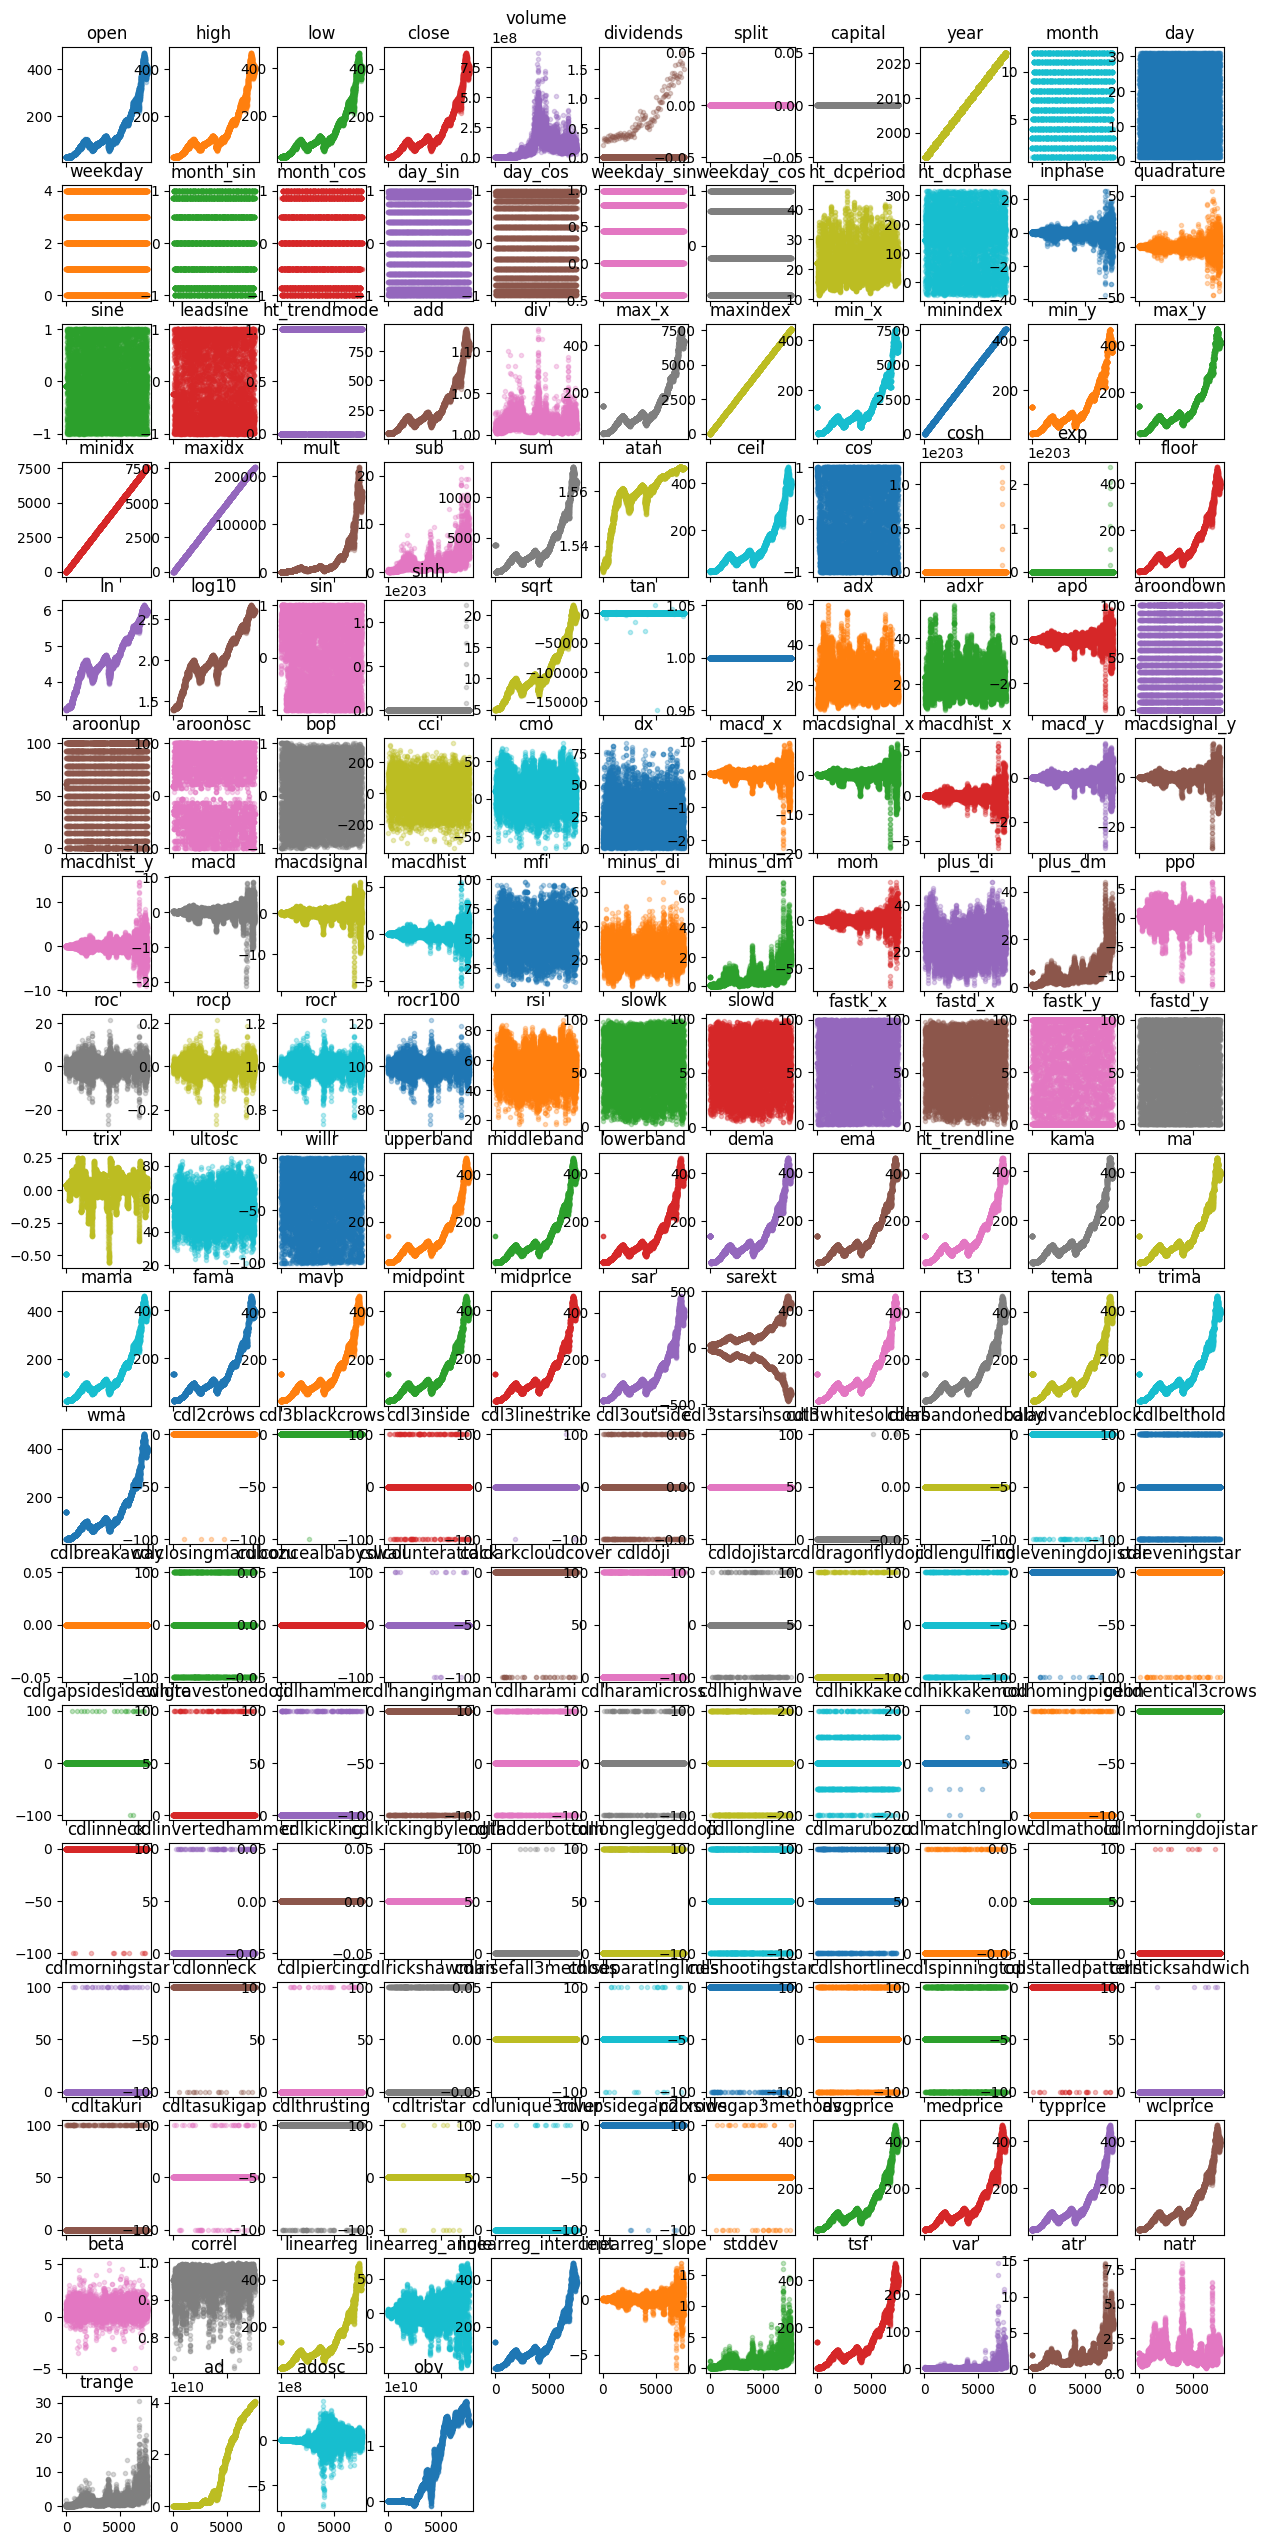

In [8]:
#visua;ize the dataset
clean_data.plot(style='.', subplots=True, legend=False, use_index=False, alpha=0.3,
                title=list(clean_data.columns), layout=(18,11), figsize=(15,32)); #colormap="winter"

##### The visualizations show that there are certain 'outliers' lie within some features such as 'max_x' and 'max_y'. However, outliers do not necessarily mean they are invalid data points. Moreover, there are some features exhibiting triviality as they contain only same values. Performing feature selection can remove the unimportant features. The appropriate algorithm will be using tree algorithms such as Random Forest which are not sensitive to outliers.

In [9]:
#scale the data between -1 and 1
#useful for svm or knn
#little effect on random forest
transformed_data = clean_data
scaler = MinMaxScaler(feature_range=(-1,1))
transformed_data.iloc[:,:] = scaler.fit_transform(transformed_data)
transformed_data.head()

C:\Users\YLS\AppData\Local\Temp\ipykernel_6124\2392609805.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  transformed_data.iloc[:,:] = scaler.fit_transform(transformed_data)


,open,high,low,close,volume,dividends,split,capital,year,month,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
key_0,,,,,,,,,,,,,,,,,,,,,
1993-01-29,-0.998554,-0.998877,-0.997576,-0.998630,-0.997708,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0.325532,-0.870983,-0.49907,-0.978677,-0.757804,-0.722674,-0.877188,-1.000000,0.287123,-0.904728
1993-02-01,-0.998554,-0.998156,-0.997010,-0.997824,-0.998909,-1.0,-1.0,-1.0,-1.0,-0.818182,...,0.325532,-0.870983,-0.49907,-0.978677,-0.757804,-0.722674,-0.990611,-0.999976,0.287123,-0.904677
1993-02-02,-0.997912,-0.997835,-0.996606,-0.997583,-0.999550,-1.0,-1.0,-1.0,-1.0,-0.818182,...,0.325532,-0.870983,-0.49907,-0.978677,-0.757804,-0.722674,-0.992970,-0.999969,0.287123,-0.904655
1993-02-03,-0.997430,-0.996632,-0.995959,-0.996374,-0.998796,-1.0,-1.0,-1.0,-1.0,-0.818182,...,0.325532,-0.870983,-0.49907,-0.978677,-0.757804,-0.722674,-0.983538,-0.999946,0.287123,-0.904599
1993-02-04,-0.995984,-0.995990,-0.995717,-0.995890,-0.998792,-1.0,-1.0,-1.0,-1.0,-0.818182,...,0.325532,-0.974900,-0.49907,-0.999656,-0.757804,-0.722674,-0.978824,-0.999928,0.287123,-0.904543


##### All the features are standardize that they range between -1 and 1. This step is trivial for Random Forest or Decision Tree classifier, while it helps improve the performance when using SVM or KNN classifier which uses distance vector. 

In [10]:
#create new column to indicate rise/drop after 5 days
#observed that rise is about 1000 more than drop
transformed_data['target'] = np.where(transformed_data.close.shift(-5) > transformed_data.close, 1, -1)
transformed_data['target'].value_counts()

 1    4431
-1    3169
Name: target, dtype: int64

##### It can seen that the difference in number is more than 1000. This means that there will be some bias in the dataset, which will affect the classification.

In [11]:
#pearson correlation
cor = transformed_data.corr()
abs(cor['target']).sort_values(ascending=False)

target                 1.000000
fastd_y                0.055110
fastk_x                0.053218
fastd_x                0.048872
fastk_y                0.048776
slowk                  0.048624
month_cos              0.042904
ad                     0.036188
cci                    0.035378
cdlclosingmarubozu     0.035211
obv                    0.034954
bop                    0.032102
minus_di               0.031163
slowd                  0.031068
natr                   0.029873
cdlharami              0.029422
dividends              0.029189
cdlunique3river        0.028533
cdl3outside            0.028383
weekday_sin            0.026839
macdhist_y             0.024713
cdlengulfing           0.024481
day_cos                0.023906
cdlstalledpattern      0.023817
adosc                  0.023247
cdllongline            0.022962
cdltasukigap           0.022773
cdlpiercing            0.022021
month                  0.021775
cdlshootingstar        0.021577
maxindex               0.020957
maxidx  

##### The pearson correlation is used to investigate the direct correlation between each independent variable and traget variable. The features that give NaN in pearson coefficient will be removed.

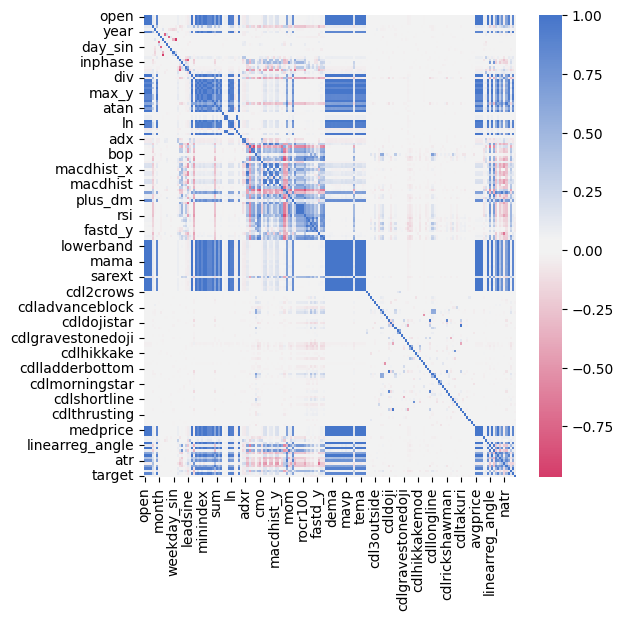

In [12]:
#remove uncorrelated features
transformed_data = transformed_data[cor['target'].dropna().index.to_list()]
cor = transformed_data.corr()
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(0, 255, sep=9, n=256)
sns.heatmap(cor, cmap=cmap, linewidths=.001);

##### As shown that all features exhibit weak correaltion with the target varaible.

In [13]:
abs(cor.target).describe()

count    181.000000
mean       0.018162
std        0.074162
min        0.000228
25%        0.006355
50%        0.009094
75%        0.017325
max        1.000000
Name: target, dtype: float64

##### Reducing dimentionality may improve the accuracy. Hence, here will remove some features that has very little correlation with the target.

In [14]:
#remove the least correlated features
selected_data = transformed_data[cor.target[cor.target > 0.019].index.to_list()]
selected_data.head()

,year,month,month_cos,day_cos,weekday_sin,inphase,maxindex,minindex,minidx,maxidx,tan,macdhist_y,minus_di,cdlharami,cdlharamicross,cdlpiercing,ad,obv,target
key_0,,,,,,,,,,,,,,,,,,,
1993-01-29,-1.0,-1.000000,0.866025,0.978148,-1.000000,0.205515,-1.0,-1.0,-1.0,-1.0,0.843654,-0.235135,-0.386746,0.0,0.0,-1.0,-1.000000,-0.904728,1
1993-02-01,-1.0,-0.818182,0.500000,0.978148,-0.384043,0.205515,-1.0,-1.0,-1.0,-1.0,0.843656,-0.235135,-0.386746,0.0,0.0,-1.0,-0.999976,-0.904677,1
1993-02-02,-1.0,-0.818182,0.500000,0.913545,0.725873,0.205515,-1.0,-1.0,-1.0,-1.0,0.843657,-0.235135,-0.386746,0.0,0.0,-1.0,-0.999969,-0.904655,1
1993-02-03,-1.0,-0.818182,0.500000,0.809017,1.000000,0.205515,-1.0,-1.0,-1.0,-1.0,0.843660,-0.235135,-0.386746,0.0,0.0,-1.0,-0.999946,-0.904599,-1
1993-02-04,-1.0,-0.818182,0.500000,0.669131,0.231914,0.205515,-1.0,-1.0,-1.0,-1.0,0.843662,-0.235135,-0.386746,0.0,0.0,-1.0,-0.999928,-0.904543,-1


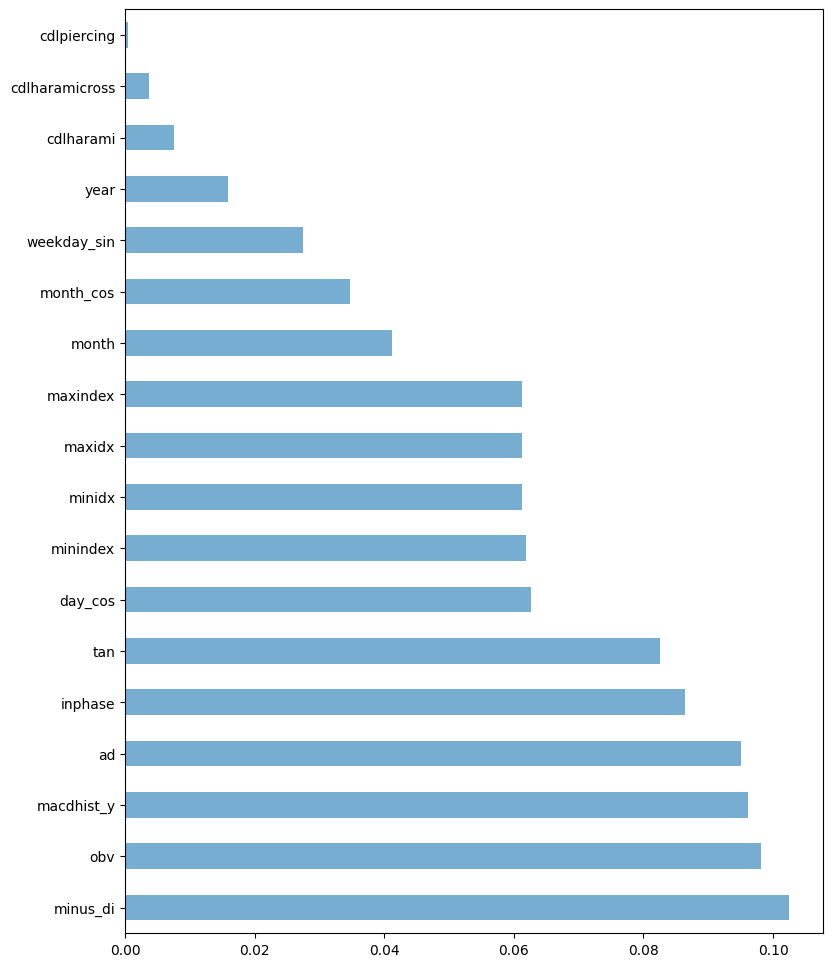

In [15]:
#feature importance using randomforest
x = selected_data.drop('target', axis=1)
y = selected_data.target
#split data for train and test
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=3, shuffle=True)

#fit the model
model = rfc()
model.fit(train_x, train_y)

feature_importance = pd.Series(model.feature_importances_, index=selected_data.drop('target', axis=1).columns)
feature_importance.nlargest(len(selected_data)).plot(kind='barh', alpha=.6, figsize=(9,12));

##### From the barchart, most of the features exhibit certain degree of importance. It would be better to keep most of them.

In [16]:
feature_importance.describe()

count    18.000000
mean      0.055556
std       0.034411
min       0.000472
25%       0.029309
50%       0.061299
75%       0.085450
max       0.102527
dtype: float64

In [17]:
#recursive feature elimination with cross-validation using Random Forest to find the optimal number of features and the features
#feature selection can be done by setting a threshold if this step takes a lot of time

model = rfc()
rfecv = RFECV(estimator=model, step=1, cv=6, scoring='accuracy') #use 6-fold cross validation
rfecv = rfecv.fit(train_x, train_y)
optimal_features = train_x.columns[rfecv.support_]
print(len(optimal_features))
print(optimal_features)

13
Index(['month', 'month_cos', 'day_cos', 'inphase', 'maxindex', 'minindex',
       'minidx', 'maxidx', 'tan', 'macdhist_y', 'minus_di', 'ad', 'obv'],
      dtype='object')


##### As observed that, the optimal features selected by recursive feature elimination with cross validation are those that exhibits high importance on the feature importance barchart.

In [18]:
# remove features with very little importance
# selected_data = selected_data[feature_importance[feature_importance > 0.003].index.to_list()]
# choose features from recursive cross validation

selected_data = selected_data[optimal_features]
selected_data.head()

,month,month_cos,day_cos,inphase,maxindex,minindex,minidx,maxidx,tan,macdhist_y,minus_di,ad,obv
key_0,,,,,,,,,,,,,
1993-01-29,-1.000000,0.866025,0.978148,0.205515,-1.0,-1.0,-1.0,-1.0,0.843654,-0.235135,-0.386746,-1.000000,-0.904728
1993-02-01,-0.818182,0.500000,0.978148,0.205515,-1.0,-1.0,-1.0,-1.0,0.843656,-0.235135,-0.386746,-0.999976,-0.904677
1993-02-02,-0.818182,0.500000,0.913545,0.205515,-1.0,-1.0,-1.0,-1.0,0.843657,-0.235135,-0.386746,-0.999969,-0.904655
1993-02-03,-0.818182,0.500000,0.809017,0.205515,-1.0,-1.0,-1.0,-1.0,0.843660,-0.235135,-0.386746,-0.999946,-0.904599
1993-02-04,-0.818182,0.500000,0.669131,0.205515,-1.0,-1.0,-1.0,-1.0,0.843662,-0.235135,-0.386746,-0.999928,-0.904543


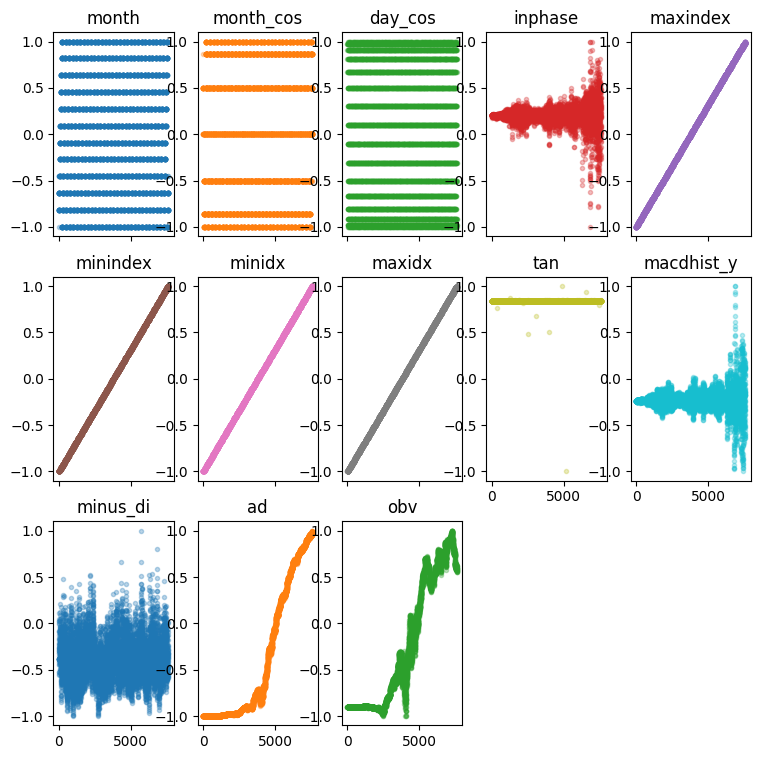

In [19]:
#visualize the final data before machine learning
selected_data.plot(style='.', subplots=True, legend=False, use_index=False, alpha=0.3,
                title=list(selected_data.columns), layout=(3,5), figsize=(9,9)); #colormap="winter"

##### As mentioned, feature selection has successfully remove all the trivial features and some unimportant features. There are still a small numer of 'outliers' being trained, however, using Random Forest.

In [20]:
#prepare train and test sets
final_data = selected_data
x = final_data
y = np.where(transformed_data.close.shift(-5) > transformed_data.close, 1, -1)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=3, shuffle=True)

##### The train and test data are splitted randomly from the original dataset. The time-series data can be randomly splitted since the date information and its trigonometry functions were computed and made to be the independent variables.

246


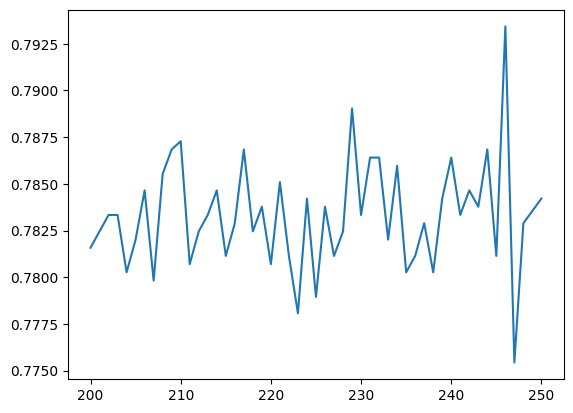

In [21]:
# tune hyperparameters to get highest accuracy
accuracy = []
parameter = np.linspace(200, 250, num=50, dtype='int')
for n in parameter:
    model = rfc(n_estimators=n, max_depth=98)
    model.fit(train_x, train_y)
    prediction = model.predict(test_x)
    accuracy.append(model.score(test_x, test_y))
pd.Series(accuracy,parameter).plot()
print(pd.Series(accuracy,parameter).idxmax())

              precision    recall  f1-score   support

          -1       0.78      0.66      0.72       963
           1       0.78      0.86      0.82      1317

    accuracy                           0.78      2280
   macro avg       0.78      0.76      0.77      2280
weighted avg       0.78      0.78      0.78      2280



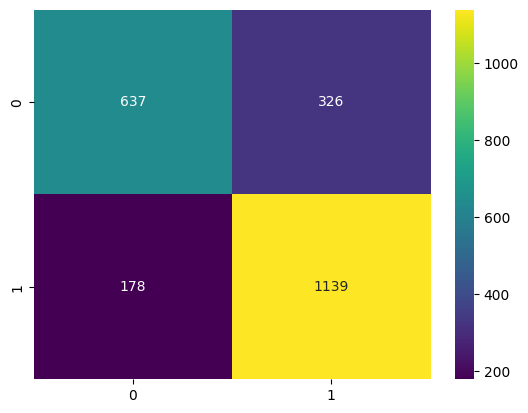

In [22]:
#perform prediction and show report
#default parameter also yield good accuracy
model = rfc(n_estimators=277, max_depth=98)
model.fit(train_x, train_y)
prediction = model.predict(test_x)
sns.heatmap(confusion_matrix(test_y, prediction), cmap='viridis', annot=True, fmt='d');
print(classification_report(test_y, prediction))

In [23]:
#save the model
#load the model and predict the whole dataset
#the new accuracy should be 0.7+0.3*previous accuracy
joblib.dump(model, "stock_movement_rfc.pkl") 
loaded_model = joblib.load("stock_movement_rfc.pkl")
new_prediction = loaded_model.predict(final_data)
print(classification_report(y, new_prediction))

              precision    recall  f1-score   support

          -1       0.94      0.90      0.92      3169
           1       0.93      0.96      0.94      4431

    accuracy                           0.93      7600
   macro avg       0.93      0.93      0.93      7600
weighted avg       0.93      0.93      0.93      7600



<h2> 2. Regression using LSTM </h2>

In [24]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, regularizers

In [25]:
# Define API endpoint and parameters
api_key = 'your_api_key'
symbol = 'AAPL'
function = 'TIME_SERIES_DAILY_ADJUSTED'
outputsize = 'full'
api_url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize={outputsize}&apikey={api_key}'

# Call API and retrieve data
response = requests.get(api_url)
data = response.json()

In [26]:
# Extract time series data
ts_data = data['Time Series (Daily)']
df = pd.DataFrame.from_dict(ts_data, orient='index').astype(float).sort_index(ascending=True)

df = df.rename(columns={'1. open':'open', '2. high':'high', '3. low':'low', '4. close':'close', 
                        '5. adjusted close':'adj_close', '6. volume':'volume', '7. dividend amount':'dividend', 
                        '8. split coefficient':'split_coeff'})
# Print the first 10 rows of the DataFrame
print(df.head(10))

             open   high    low  close  adj_close     volume  dividend  \
1999-11-01  80.00  80.69  77.37  77.62   0.589041  2487300.0       0.0   
1999-11-02  78.00  81.69  77.31  80.25   0.608999  3564600.0       0.0   
1999-11-03  81.62  83.25  81.00  81.50   0.618485  2932700.0       0.0   
1999-11-04  82.06  85.37  80.62  83.62   0.634574  3384700.0       0.0   
1999-11-05  84.62  88.37  84.00  88.31   0.670165  3721500.0       0.0   
1999-11-08  87.75  97.73  86.75  96.37   0.731330  8490400.0       0.0   
1999-11-09  94.37  94.50  88.00  89.62   0.680106  7224800.0       0.0   
1999-11-10  88.25  93.25  88.12  91.44   0.693918  5159800.0       0.0   
1999-11-11  91.59  92.62  89.87  92.25   0.700065  2409600.0       0.0   
1999-11-12  91.94  92.00  87.37  90.62   0.687695  2491600.0       0.0   

            split_coeff  
1999-11-01          1.0  
1999-11-02          1.0  
1999-11-03          1.0  
1999-11-04          1.0  
1999-11-05          1.0  
1999-11-08          1.0  
199

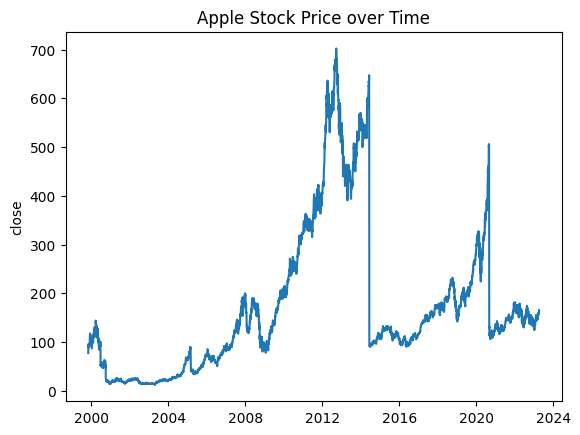

In [27]:
# Use only year format for x-axis
df.index = pd.to_datetime(df.index)
df['year'] = df.index.year

# Perform EDA using Seaborn
sns.lineplot(data=df, x=df.index, y='close')
plt.title('Apple Stock Price over Time')
plt.show()

In [28]:
# Prepare the data
data = df.filter(['close']).values
train_len = int(len(data) * 0.8) # 80% for training

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

train_data = scaled_data[0:train_len, :]
x_train = []
y_train = []
win_size = 72
for i in range(win_size, len(train_data)):
    x_train.append(train_data[i-win_size:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the model
model = tf.keras.Sequential([
    layers.LSTM(units=32, return_sequences=True, input_shape=(win_size, 1)),
    layers.LSTM(units=32, return_sequences=True, dropout=.5),
    layers.LSTM(units=32, return_sequences=True, dropout=.5),
    layers.LSTM(units=32, dropout=.5),
    layers.Dense(units=32),
    layers.Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1)
]

model.fit(x_train, y_train, batch_size=16, epochs=10, validation_split=0.3, callbacks=my_callbacks)

# Test the model
test_data = scaled_data[train_len - win_size:, :]
x_test = []
y_test = data[train_len:, :]
for i in range(win_size, len(test_data)):
    x_test.append(test_data[i-win_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Evaluate the model
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
print('Root Mean Squared Error:', rmse)

Epoch 1/10
204/204 [==============================] - ETA: 0s - loss: 0.0062
Epoch 1: saving model to best_model.h5
204/204 [==============================] - 34s 116ms/step - loss: 0.0062 - val_loss: 0.0097
Epoch 2/10
204/204 [==============================] - ETA: 0s - loss: 0.0014
Epoch 2: saving model to best_model.h5
204/204 [==============================] - 22s 107ms/step - loss: 0.0014 - val_loss: 0.0072
Epoch 3/10
204/204 [==============================] - ETA: 0s - loss: 0.0012
Epoch 3: saving model to best_model.h5
204/204 [==============================] - 24s 119ms/step - loss: 0.0012 - val_loss: 0.0090
Epoch 4/10
204/204 [==============================] - ETA: 0s - loss: 0.0011
Epoch 4: saving model to best_model.h5
204/204 [==============================] - 24s 117ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 5/10
204/204 [==============================] - ETA: 0s - loss: 0.0012
Epoch 5: saving model to best_model.h5
204/204 [==============================] - 23s 114ms

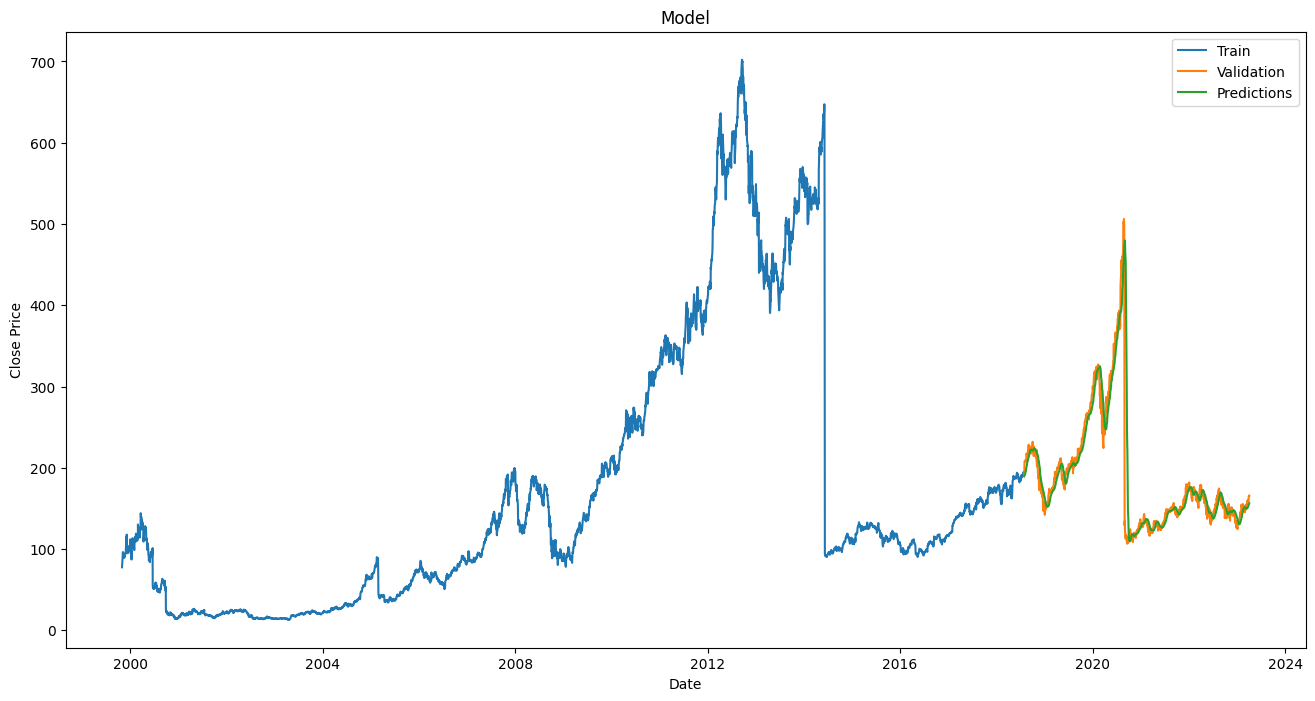

In [29]:
# Visualize the results
train = df.filter(['close'])[:train_len]
valid = df.filter(['close'])[train_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'])
plt.show()